# Analisis Sentimen Ulasan Aplikasi DANA menggunakan Teknik Big Data Analytics

**Latar Belakang:**

Aplikasi DANA adalah salah satu aplikasi dompet digital populer di Indonesia. Ulasan pengguna di Google Playstore memberikan wawasan berharga tentang pengalaman dan persepsi pengguna terhadap aplikasi tersebut. Dengan menganalisis ulasan ini, kita dapat mengidentifikasi sentimen umum pengguna, aspek-aspek yang mereka sukai atau tidak sukai, dan tren temporal dalam ulasan. Analisis ini akan memanfaatkan teknik big data analytics dan natural language processing (NLP) untuk mengolah dan memahami data yang besar dan tidak terstruktur.

**Tujuan:**

* Menganalisis distribusi sentimen ulasan pengguna terhadap aplikasi DANA.
* Mengidentifikasi aspek-aspek yang paling sering dibahas oleh pengguna.
* Melakukan analisis tren temporal untuk melihat perubahan sentimen dari waktu ke waktu.
* Menggunakan teknik machine learning untuk memprediksi sentimen ulasan berdasarkan konten teks.

# Deskripsi Dataset

50k Datapoints berlabel Ulasan Aplikasi DANA, diambil dari Google Playstore Indonesia.

Data tersebut berisi 5 kolom:

1.   UserName
2.   score
3.   at
4.   content
5.   sentimen

Link Dataset:
https://www.kaggle.com/datasets/alexmariosimanjuntak/dana-app-sentiment-review-on-playstore-indonesia/data

# 1. Install Library & Load Dataset

In [58]:
# Install & Import Library
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud Sastrawi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [59]:
# Load dataset
df = pd.read_csv('review_dana_labelled.csv')

# 2. Data Cleaning

In [60]:
# Display the first few rows of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 50000 entries, 0 to 49999

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   userName  50000 non-null  object

 1   score     50000 non-null  int64 

 2   at        50000 non-null  object

 3   content   50000 non-null  object

 4   sentimen  50000 non-null  object

dtypes: int64(1), object(4)

memory usage: 1.9+ MB


In [61]:
# # Data Cleaning
# Convert 'at' column to datetime
df['at'] = pd.to_datetime(df['at'])

# Check for missing values
print(df.isnull().sum())

# Remove duplicate reviews if any
df = df.drop_duplicates(subset=['userName', 'content'])

# Basic statistics
print(df.describe())

# Menghapus nilai yang hilang
df.dropna(subset=['content'], inplace=True)

# Mengonversi teks menjadi lowercase
df['content'] = df['content'].apply(lambda x: x.lower())

# Menghapus karakter spesial dan angka
df['content'] = df['content'].apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))

userName    0

score       0

at          0

content     0

sentimen    0

dtype: int64

              score                             at

count  49976.000000                          49976

mean       3.710301  2024-01-24 03:48:14.552145152

min        1.000000            2023-12-31 16:28:46

25%        2.000000     2024-01-12 10:54:02.500000

50%        5.000000            2024-01-24 15:43:39

75%        5.000000            2024-02-04 14:24:34

max        5.000000            2024-02-15 11:24:56

std        1.709894                            NaN


In [62]:
df.groupby('sentimen').head()

,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,dana mmg keren mantap,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,saldo hilang karena no lama hilang ganti no sa...,NEGATIVE
5,Kiki57,3,2024-02-15 11:21:13,mayan,POSITIVE
6,Parhan Parhan,1,2024-02-15 11:19:32,udah gua hapus dana ya ilang ya udah juta leb...,NEGATIVE
7,Dewi Anggreni,5,2024-02-15 11:19:22,baik,POSITIVE
8,Bang Ewok13,1,2024-02-15 11:18:01,tolong untuk sistem keamanan di perbaiki kalau...,NEUTRAL
9,M Alifian,5,2024-02-15 11:17:58,mempermudah transfer,POSITIVE


# 3. Exploratory Data Analysis (EDA)

In [63]:
# Data types and basic statistics
print(df.dtypes)
print(df.describe(include='all'))

userName            object

score                int64

at          datetime64[ns]

content             object

sentimen            object

dtype: object

              userName         score                             at content  \

count            49976  49976.000000                          49976   49976   

unique           48177           NaN                            NaN   30016   

top     Rahmat Hidayat           NaN                            NaN  mantap   

freq                15           NaN                            NaN    2501   

mean               NaN      3.710301  2024-01-24 03:48:14.552145152     NaN   

min                NaN      1.000000            2023-12-31 16:28:46     NaN   

25%                NaN      2.000000     2024-01-12 10:54:02.500000     NaN   

50%                NaN      5.000000            2024-01-24 15:43:39     NaN   

75%                NaN      5.000000            2024-02-04 14:24:34     NaN   

max                NaN      5.000000         

Sentiment Distribution:

 sentimen

POSITIVE    26535

NEGATIVE    17069

NEUTRAL      6372

Name: count, dtype: int64


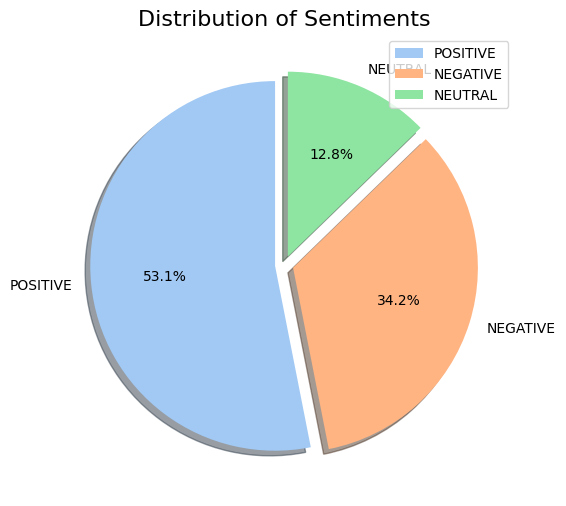

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the sentiment distribution
sentiment_distribution = df['sentimen'].value_counts()

# Print the sentiment distribution
print("Sentiment Distribution:\n", sentiment_distribution)

# Membuat warna yang menarik menggunakan seaborn
colors = sns.color_palette('pastel')[0:len(df['sentimen'].unique())]

# Plot distribusi sentimen
plt.figure(figsize=(10, 6))
distribution_of_sentiment = df['sentimen'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=90, 
    shadow=True, 
    explode=(0.05, 0.05, 0.05)  # Memberikan efek explode pada setiap segmen
)

# Menambahkan judul
plt.title('Distribution of Sentiments', fontsize=16)

# Menghapus label default pada sumbu y
plt.ylabel('')

# Menambahkan legend
plt.legend(labels=df['sentimen'].value_counts().index, loc="upper right")

# Menampilkan plot
plt.show()


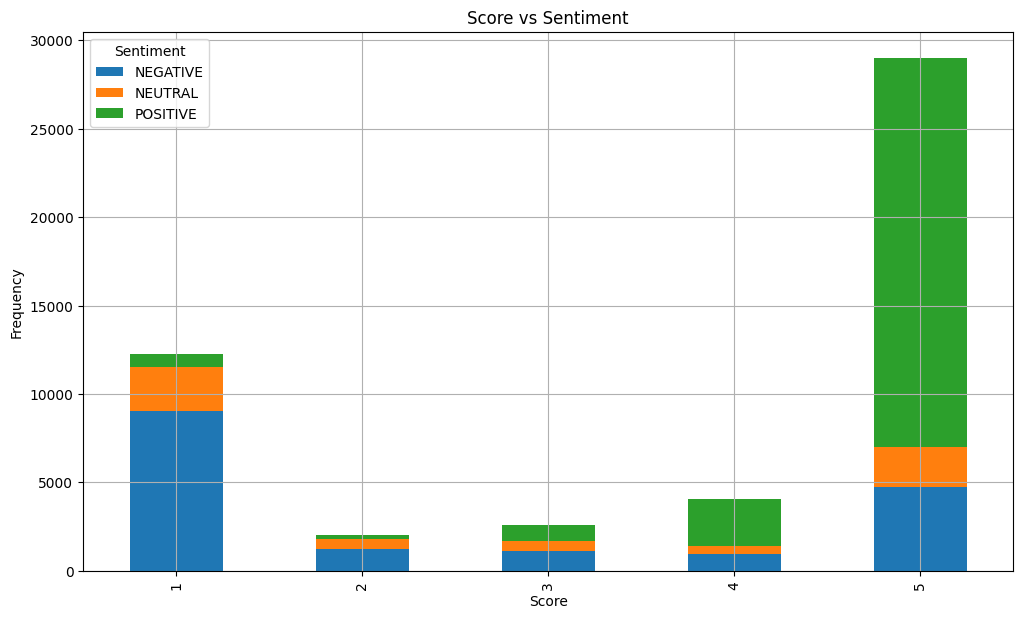

sentimen  NEGATIVE  NEUTRAL  POSITIVE

score                                

1             9015     2540       724

2             1246      530       271

3             1131      550       897

4              959      462      2620

5             4718     2290     22023


In [65]:
# Perbandingan antara skor dan sentimen
score_sentiment = pd.crosstab(df['score'], df['sentimen'])
score_sentiment.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score vs Sentiment')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()


print(score_sentiment)

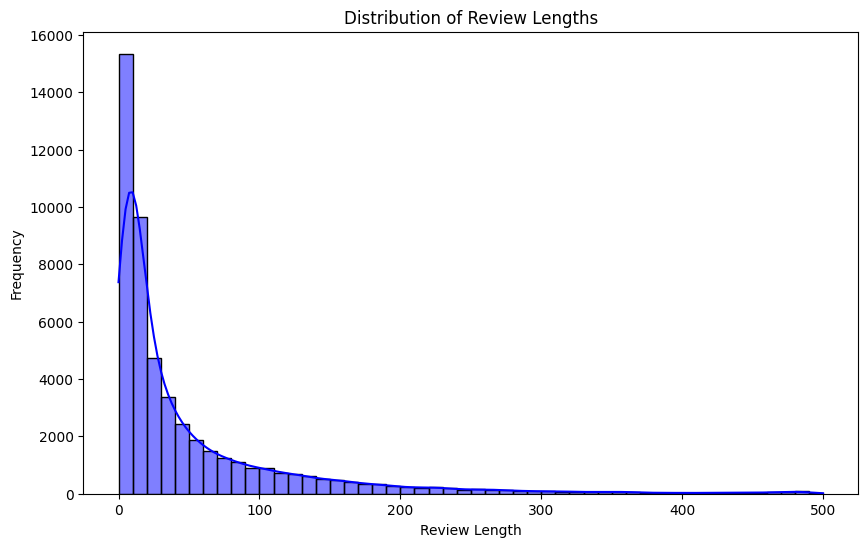

C:\Users\Fadhil\AppData\Local\Temp\ipykernel_33744\2579617371.py:13: FutureWarning: 



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



  sns.boxplot(x='sentimen', y='review_length', data=df, palette='viridis')


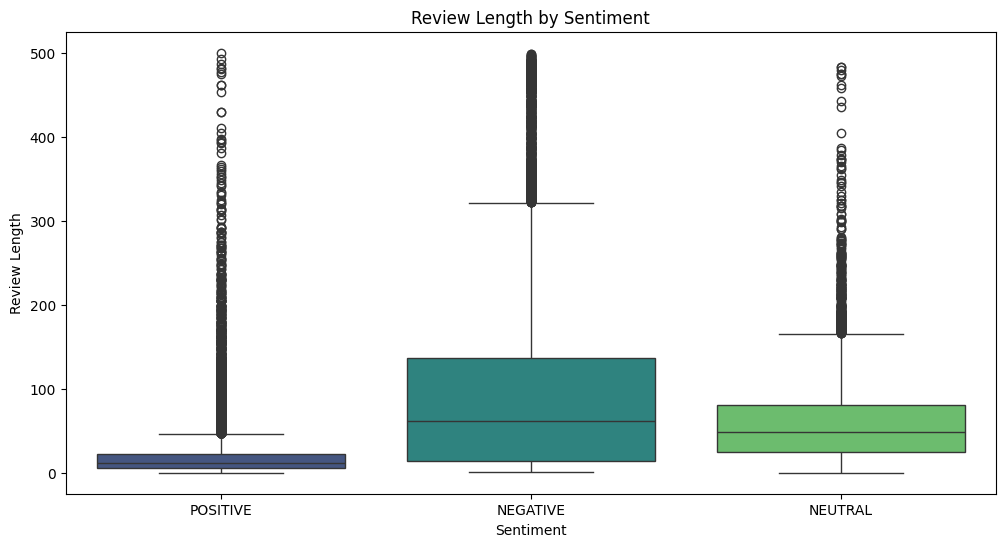

In [66]:
# Add a column for review length
df['review_length'] = df['content'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot of review length by sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentimen', y='review_length', data=df, palette='viridis')
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()


### Observasi dan Implikasi dari Distribusi Sentimen:
* Sentimen Positif:

    1. Observasi: Ulasan dengan sentimen positif cenderung lebih pendek. Rata-rata panjang ulasan relatif rendah dan terdapat lebih sedikit pencilan.
    2. Implikasi: Ini bisa menunjukkan bahwa pengguna yang puas memberikan umpan balik yang lebih singkat, seringkali berupa pujian cepat atau saran singkat. Pencilan yang lebih sedikit menunjukkan konsistensi panjang ulasan di antara sentimen positif.
* Sentimen Negatif:

    1. Observasi: Ulasan negatif umumnya lebih panjang. Panjang rata-rata lebih tinggi menunjukkan bahwa pengguna yang tidak puas menulis ulasan yang lebih mendetail. Ada juga pencilan yang lebih ekstrem, menunjukkan beberapa pengguna menulis keluhan yang sangat panjang.
    2. Implikasi: Pengguna yang tidak puas cenderung memberikan penjelasan rinci tentang apa yang salah atau apa yang mereka tidak suka. Umpan balik yang mendetail ini bisa sangat berharga untuk mengidentifikasi area spesifik yang perlu diperbaiki. Kehadiran pencilan ekstrem mungkin menunjukkan masalah serius yang sangat mempengaruhi pengalaman pengguna dan perlu mendapat perhatian lebih.
* Sentimen Netral:

    1. Observasi: Ulasan netral memiliki panjang rata-rata yang berada di antara ulasan positif dan negatif. Terdapat pencilan, tetapi tidak sebanyak pencilan ekstrem seperti ulasan negatif.
    2. Implikasi: Ulasan netral mungkin mengandung umpan balik yang seimbang, mungkin menunjukkan kelebihan dan kekurangan atau mengekspresikan ketidakpedulian. Mereka memberikan tingkat detail yang moderat, yang bisa berguna untuk memahami masalah umum yang mungkin tidak terlalu parah tetapi masih patut diperhatikan.

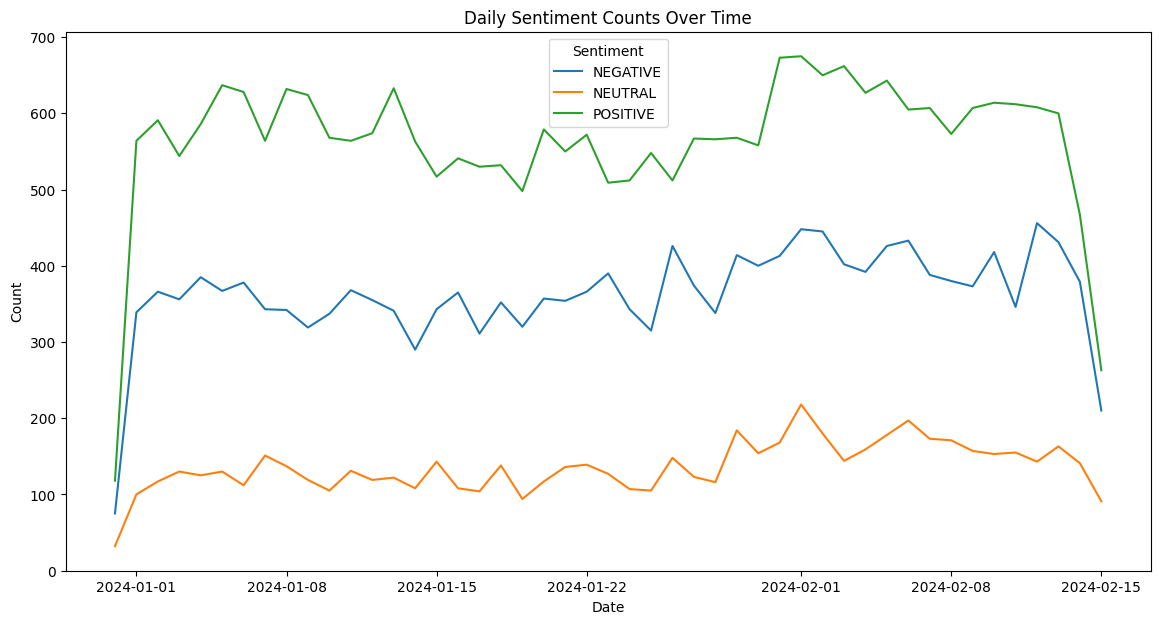

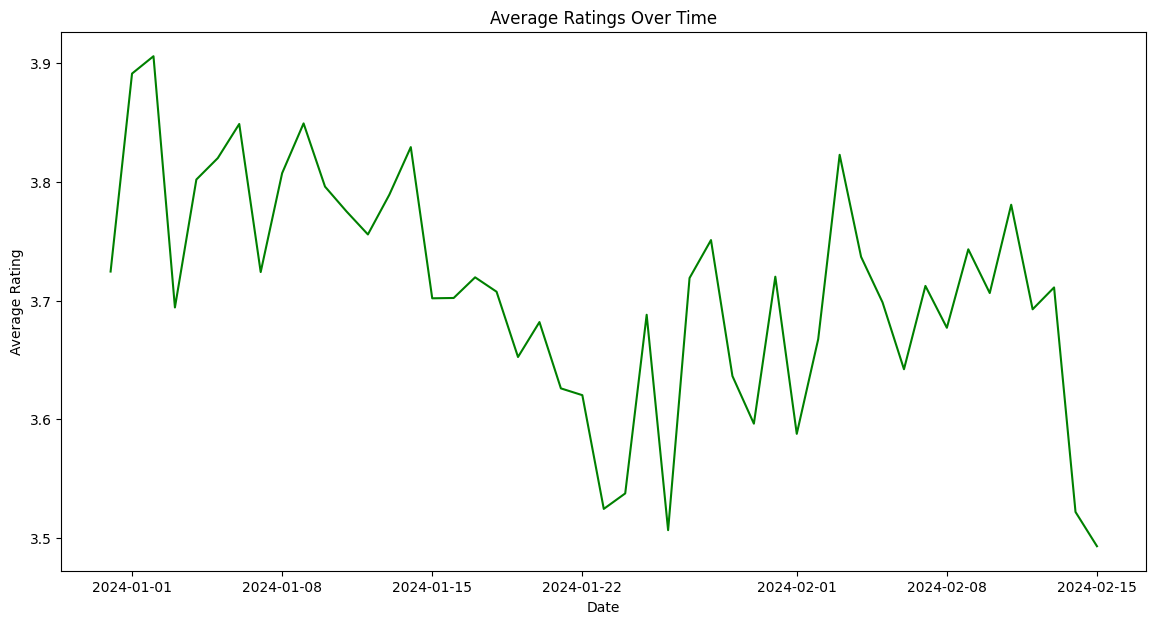

In [67]:
# Convert 'at' column to datetime
df['at'] = pd.to_datetime(df['at'])

# Aggregate data by date
daily_sentiment = df.groupby(df['at'].dt.date)['sentimen'].value_counts().unstack().fillna(0)
daily_ratings = df.groupby(df['at'].dt.date)['score'].mean()

# Plot sentiments over time
plt.figure(figsize=(14, 7))
daily_sentiment.plot(ax=plt.gca())
plt.title('Daily Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Plot average ratings over time
plt.figure(figsize=(14, 7))
daily_ratings.plot(ax=plt.gca(), color='green')
plt.title('Average Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()


In [68]:
# Cross-tabulate sentiments and scores
sentiment_score_proportion = pd.crosstab(df['sentimen'], df['score'], normalize='index')

# Convert proportions to percentages with formatting
sentiment_score_percent = sentiment_score_proportion.applymap(lambda x: "{:.2f}%".format(x * 100))

# Print the sentiment vs. score percentage table
print(sentiment_score_percent)

score          1      2      3      4       5

sentimen                                     

NEGATIVE  52.82%  7.30%  6.63%  5.62%  27.64%

NEUTRAL   39.86%  8.32%  8.63%  7.25%  35.94%

POSITIVE   2.73%  1.02%  3.38%  9.87%  83.00%


C:\Users\Fadhil\AppData\Local\Temp\ipykernel_33744\1097618298.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.

  sentiment_score_percent = sentiment_score_proportion.applymap(lambda x: "{:.2f}%".format(x * 100))


Skor 1:
* 52,82% ulasan dengan skor 1 memiliki sentimen negatif.
* 39,86% ulasan dengan skor 1 memiliki sentimen netral.
* 2,73% ulasan dengan skor 1 memiliki sentimen positif.

Skor 5:
* 27,64% ulasan dengan skor 5 memiliki sentimen negatif.
* 35,94% ulasan dengan skor 5 memiliki sentimen netral.
* 82,99% ulasan dengan skor 5 memiliki sentimen positif.

Singkatnya, skor yang lebih tinggi lebih cenderung memiliki sentimen positif, sementara skor yang lebih rendah lebih cenderung memiliki sentimen negatif.

## Karakteristik Dataset

* Teks Informal atau Formal:

Dataset ini terdiri dari ulasan aplikasi dari Google Playstore, yang cenderung informal. Pengguna sering menggunakan bahasa sehari-hari, singkatan, dan bahasa gaul dalam ulasan mereka.
### Jumlah Item Data:

* Total ada 50,000 ulasan dalam dataset ini.

### Jumlah Kelas (Kategori):

Ada tiga kategori sentimen dalam dataset ini:
POSITIVE
NEGATIVE
NEUTRAL
### Distribusi Kelas:

Berdasarkan visualisasi distribusi sentimen, berikut adalah jumlah ulasan di tiap kategori:

POSITIVE: 26,000 ulasan

NEGATIVE: 17,000 ulasan

NEUTRAL: 7,000 ulasan

In [69]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\Fadhil\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
import nltk

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Define your DataFrame (df) before using it
# df = pd.read_csv('your_data.csv')  # Example for loading data

# Memuat stopwords tambahan dari file CSV
additional_stopwords_path = 'stopwordbahasa.csv'  # Ganti dengan path yang sesuai
additional_stopwords_df = pd.read_csv(additional_stopwords_path, header=None)
additional_stopwords = additional_stopwords_df[0].tolist()

# Menghapus stopwords menggunakan Sastrawi
stop_factory = StopWordRemoverFactory()
more_stopword = ['dengan', 'ia', 'bahwa', 'oleh', 'nya', 'dana']
stop_words = stop_factory.get_stop_words() + more_stopword + additional_stopwords
stop_words = set(stop_words)

# Menggunakan Stemmer dari Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Menghapus stopwords dari teks
def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

# Stemming dan lemmatization
def stem_and_lemmatize(text):
    return stemmer.stem(text)

# Apply the text processing to the DataFrame
df['content'] = df['content'].apply(remove_stopwords)
df['content'] = df['content'].apply(stem_and_lemmatize)

# Display the first few rows of the DataFrame
df.head()
# Save the result to a new CSV file
df.to_csv('processed_data.csv', index=False)


[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\Fadhil\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!


In [185]:
df = pd.read_csv("processed_data.csv")

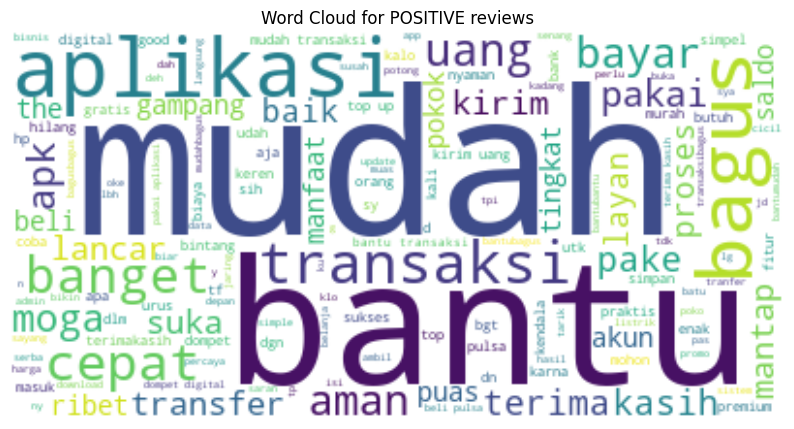

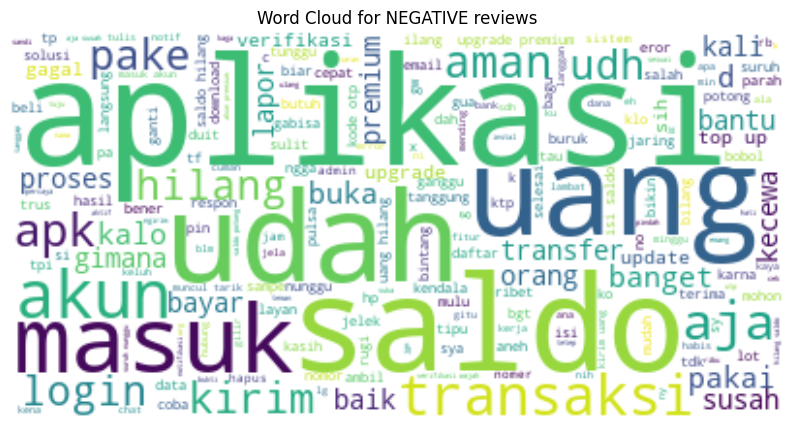

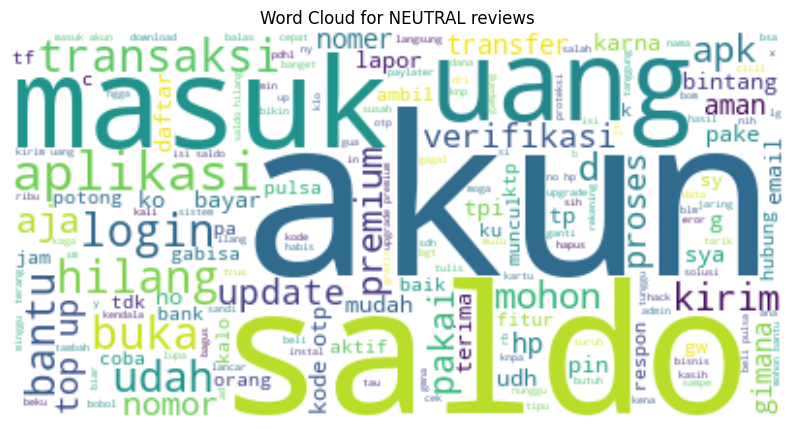

In [186]:
# Word Cloud for positive, negative, and neutral reviews
stopwords_factory = StopWordRemoverFactory()
stopwords_set = set(stopwords_factory.get_stop_words())

def generate_wordcloud(sentiment):
    text = ''.join(map(str, df[df['sentimen'] == sentiment]['content']))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {sentiment} reviews')
    plt.show()

generate_wordcloud('POSITIVE')
generate_wordcloud('NEGATIVE')
generate_wordcloud('NEUTRAL')


In [187]:
from collections import Counter

# Get top N words for each sentiment
def get_top_n_words(sentiment, n=5):
    subset = df[df['sentimen'] == sentiment]
    all_words =''.join(subset['content'].astype(str))
    word_counts = Counter(all_words.split())
    return word_counts.most_common(n)

top_words_positive = get_top_n_words('POSITIVE')
top_words_negative = get_top_n_words('NEGATIVE')
top_words_neutral = get_top_n_words('NEUTRAL')

print("Top 5 most frequent words in POSITIVE reviews:", top_words_positive)
print("Top 5 most frequent words in NEGATIVE reviews:", top_words_negative)
print("Top 5 most frequent words in NEUTRAL reviews:", top_words_neutral)

Top 5 most frequent words in POSITIVE reviews: [('mudah', 735), ('bantu', 511), ('transaksi', 494), ('aplikasi', 485), ('bagus', 424)]

Top 5 most frequent words in NEGATIVE reviews: [('saldo', 2593), ('uang', 2126), ('aplikasi', 1991), ('masuk', 1762), ('akun', 1616)]

Top 5 most frequent words in NEUTRAL reviews: [('saldo', 680), ('akun', 628), ('masuk', 535), ('uang', 463), ('aplikasi', 383)]


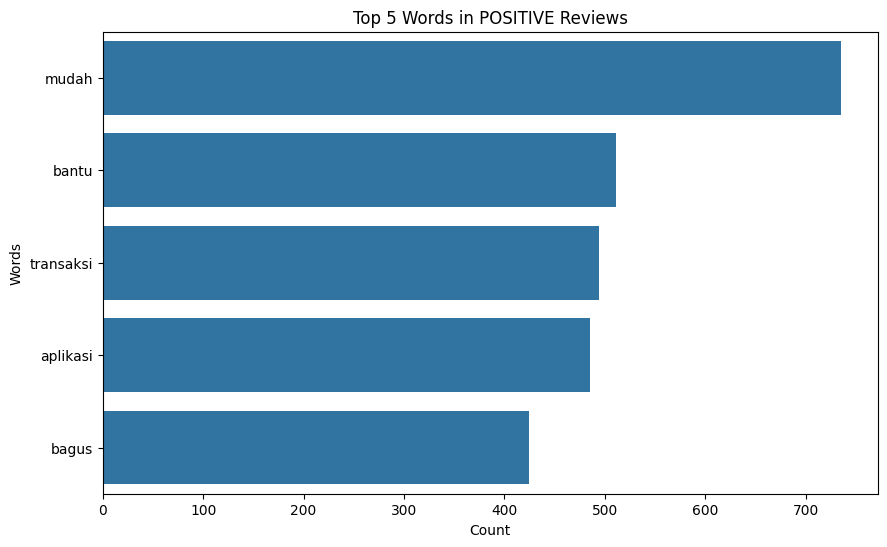

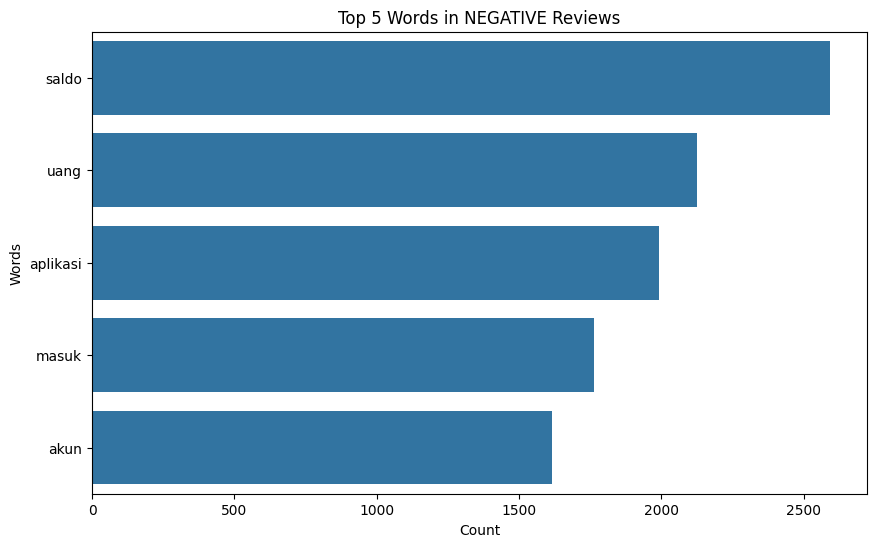

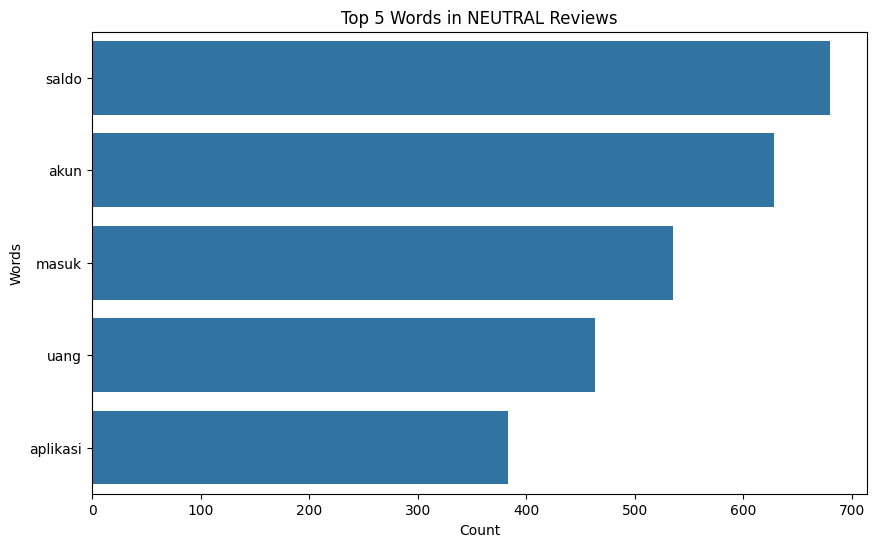

In [189]:
import seaborn as sns

def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()

plot_top_words(top_words_positive, 'Top 5 Words in POSITIVE Reviews')
plot_top_words(top_words_negative, 'Top 5 Words in NEGATIVE Reviews')
plot_top_words(top_words_neutral, 'Top 5 Words in NEUTRAL Reviews')


# 4. TVectorizing

In [190]:
# Drop rows with NaN values in the 'content' column
df = df.dropna(subset=['content'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['content'])
X = tfidf.fit_transform(df['content']).toarray()
y = df['sentimen']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. Modelling & Evaluation

## Aspect Based Sentiment Analysisi with LDA Clustering

In [191]:
from sklearn.decomposition import LatentDirichletAllocation
# Apply LDA
num_topics = 5  # Number of topics to discover
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Display the top words for each topic
feature_names = tfidf.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_idx = topic.argsort()[:-10 - 1:-1]
    top_features = [feature_names[i] for i in top_features_idx]
    topic_words[f'Topic {topic_idx + 1}'] = top_features

print("Top words for each topic:")
for topic, words in topic_words.items():
    print(topic, ": ", words)

# Assign topics to documents
df['topic'] = lda_model.transform(tfidf_matrix).argmax(axis=1)

print("Documents with their assigned topics:")
print(df[['content', 'topic']])

Top words for each topic:

Topic 1 :  ['mudah', 'transaksi', 'oke', 'cepat', 'suka', 'muas', 'aman', 'kasih', 'lumayan', 'bgus']

Topic 2 :  ['bagus', 'mantap', 'terimakasih', 'aplikasi', 'moga', 'senang', 'mantul', 'makasih', 'pokok', 'sukses']

Topic 3 :  ['puas', 'good', 'aplikasi', 'guna', 'lot', 'jos', 'best', 'the', 'coba', 'bos']

Topic 4 :  ['bantu', 'baik', 'login', 'buka', 'masuk', 'akun', 'aplikasi', 'manfaat', 'apk', 'susah']

Topic 5 :  ['saldo', 'uang', 'banget', 'aplikasi', 'keren', 'hilang', 'premium', 'top', 'upgrade', 'akun']

Documents with their assigned topics:

                                                 content  topic

0                                                  bagus      1

1                                       mmg keren mantap      4

2      ngajuin upgrade premium krna ktp buram jdi ver...      4

3         kocak diskon ml eror kaga ikhlas ngasih diskon      4

4      saldo hilang no hilang ganti no saldo tanggung...      4

...                 

In [192]:
# Assign topics to documents
df['topic'] = lda_model.transform(tfidf_matrix).argmax(axis=1)

# Map topic values to the specified labels
topic_labels = {
    0: "TRANSAKSI",   # reflecting the efficient and easy transactions mentioned in the topic
    1: "PUJIAN",      # capturing the positive sentiments and gratitude expressed in the topic
    2: "KEPUASAN PENGGUNA",      # focusing on the satisfaction and good experiences mentioned in the topic
    3: "BANTUAN & KEMUDAHAN AKSES",   # emphasizing the need for help and assistance discussed in the topic
    4: "MASALAH SALDO & UPGRADE"   # highlighting the financial and transactional aspects mentioned in the topic
}

df['topic'] = df['topic'].map(topic_labels)

# Print documents with their assigned topics
print("Documents with their assigned topics:")
print(df[['content', 'topic']])

Documents with their assigned topics:

                                                 content  \

0                                                  bagus   

1                                       mmg keren mantap   

2      ngajuin upgrade premium krna ktp buram jdi ver...   

3         kocak diskon ml eror kaga ikhlas ngasih diskon   

4      saldo hilang no hilang ganti no saldo tanggung...   

...                                                  ...   

49971                                              bagus   

49972                                        error masuk   

49973                                              bantu   

49974  knp saldo hilangada bobol akun sayagk klo bkn ...   

49975                                               good   



                           topic  

0                         PUJIAN  

1        MASALAH SALDO & UPGRADE  

2        MASALAH SALDO & UPGRADE  

3        MASALAH SALDO & UPGRADE  

4        MASALAH SALDO & UPGRADE  

...        

In [193]:
# Mengganti nama fitur berdasarkan pola tertentu
df.columns = df.columns.str.replace('topic', 'aspect')
df

,userName,score,at,content,sentimen,review_length,aspect
0,Elisya Kasni,5,2024-02-15 11:24:56,bagus,POSITIVE,5,PUJIAN
1,Rusman Man,2,2024-02-15 11:24:03,mmg keren mantap,POSITIVE,21,MASALAH SALDO & UPGRADE
2,Qiliw Sadega,1,2024-02-15 11:23:34,ngajuin upgrade premium krna ktp buram jdi ver...,NEGATIVE,210,MASALAH SALDO & UPGRADE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,kocak diskon ml eror kaga ikhlas ngasih diskon,NEGATIVE,72,MASALAH SALDO & UPGRADE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,saldo hilang no hilang ganti no saldo tanggung...,NEGATIVE,145,MASALAH SALDO & UPGRADE
...,...,...,...,...,...,...,...
49971,Marha Marha,5,2023-12-31 16:34:55,bagus,POSITIVE,5,PUJIAN
49972,Unique Laudy,1,2023-12-31 16:33:47,error masuk,NEGATIVE,22,BANTUAN & KEMUDAHAN AKSES
49973,supendi supendi,5,2023-12-31 16:30:08,bantu,POSITIVE,14,BANTUAN & KEMUDAHAN AKSES
49974,hasansend farm,1,2023-12-31 16:28:51,knp saldo hilangada bobol akun sayagk klo bkn ...,NEUTRAL,107,MASALAH SALDO & UPGRADE


In [194]:
# Save the result to a new CSV file
df.to_csv('aspect_analyis.csv', index=False)

In [195]:
df = pd.read_csv('aspect_analyis.csv')

In [200]:
# Menampilkan sampel data berdasarkan setiap aspek
samples_by_aspect = df.groupby('aspect').apply(lambda x: x.sample(n=3))

# Menampilkan hasil
samples_by_aspect

C:\Users\Fadhil\AppData\Local\Temp\ipykernel_33744\2433832021.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

  samples_by_aspect = df.groupby('aspect').apply(lambda x: x.sample(n=3))


userName  score  \
aspect                                                        
BANTUAN & KEMUDAHAN AKSES 14491            Umi Salma      5   
                          6901                 Hanas      3   
                          35140        Agus Canabian      3   
KEPUASAN PENGGUNA         5323         Aulia Safitri      5   
                          38851        Yongki Yakuza      5   
                          12330     Moonlight Sonata      1   
MASALAH SALDO & UPGRADE   41752          aufar afafi      5   
                          18221  Dalisha aghni Inaya      1   
                          21864                Nanda      1   
PUJIAN                    32515          Damar Damar      5   
                          16997        Udo AL Gaming      1   
                          38575               Vivo Y      4   
TRANSAKSI                 11296        Andriano Ajja      5   
                          28166          Dayat Putra      1   
                          21623        Widhi Pratama      5   

                                                  at  \
aspect                                                 
BANTUAN & KEMUDAHAN AKSES 14491  2024-02-02 00:09:40   
                          6901   2024-02-08 17:11:49   
                          35140  2024-01-11 12:30:35   
KEPUASAN PENGGUNA         5323   2024-02-10 08:39:17   
                          38851  2024-01-07 15:04:34   
                          12330  2024-02-03 18:34:00   
MASALAH SALDO & UPGRADE   41752  2024-01-04 17:44:19   
                          18221  2024-01-29 13:48:19   
                          21864  2024-01-26 00:53:25   
PUJIAN                    32515  2024-01-14 07:37:30   
                          16997  2024-01-30 17:54:58   
                          38575  2024-01-08 01:19:27   
TRANSAKSI                 11296  2024-02-04 16:58:25   
                          28166  2024-01-19 04:05:31   
                          21623  2024-01-26 07:04:46   

                                                                           content  \
aspect                                                                               
BANTUAN & KEMUDAHAN AKSES 14491                                        apk manfaat   
                          6901            kesini ko mlah delay kirim pulsanyaantri   
                          35140  udah download s buka salah jaringansruh update...   
KEPUASAN PENGGUNA         5323                                          jos gandos   
                          38851                                           the best   
                          12330                  uang hilang k beli paket smarfren   
MASALAH SALDO & UPGRADE   41752                                                top   
                          18221  aman bagus saldo barusan ambil orang konfirmas...   
                          21864                            agen menit ilang hubung   
PUJIAN                    32515                                             mantap   
                          16997                                             mantap   
                          38575                                              bagus   
TRANSAKSI                 11296                                         puas pakai   
                          28166                                               bgus   
                          21623    qiris pake sajatidak untk terima pembyaran laen   

                                 sentimen  review_length  \
aspect                                                     
BANTUAN & KEMUDAHAN AKSES 14491  POSITIVE             21   
                          6901   NEGATIVE             58   
                          35140  NEGATIVE            114   
KEPUASAN PENGGUNA         5323    NEUTRAL             10   
                          38851  POSITIVE              8   
                          12330   NEUTRAL             43   
MASALAH SALDO & UPGRADE   41752  POSITIVE              3   
                

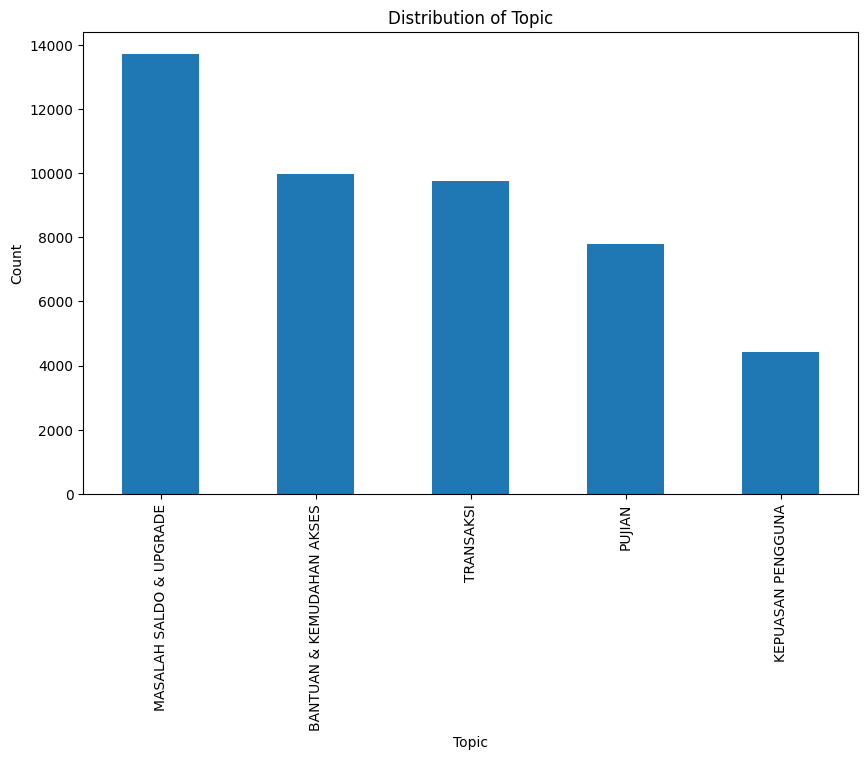

In [201]:
# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
df['aspect'].value_counts().plot(kind='bar')
plt.title('Distribution of Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()


Dengan hasil yang telah diperbarui, berikut ini adalah ringkasan satu kata untuk setiap topik:

* Topik 1: TRANSAKSI (mencerminkan pembahasan transaksi disebutkan dalam topik)
* Topik 2: PUJIAN (menangkap sentimen positif dan rasa terima kasih yang diungkapkan dalam topik)
* Topik 3: KEPUASAN PENGGUNA (berfokus pada kepuasan dan pengalaman baik yang disebutkan dalam topik)
* Topik 4: BANTUAN & KEMUDAHAN AKSES (menekankan pada kebutuhan akan bantuan dan pendampingan yang dibahas dalam topik)
* Topik 5: MASALAH SALDO & UPGRADE (menyoroti aspek keuangan dan transaksional yang disebutkan dalam topik)

Ringkasan satu kata ini memberikan representasi ringkas dari setiap tema topik, yang dapat berguna untuk memahami sentimen dan kekhawatiran yang mendasari data teks.

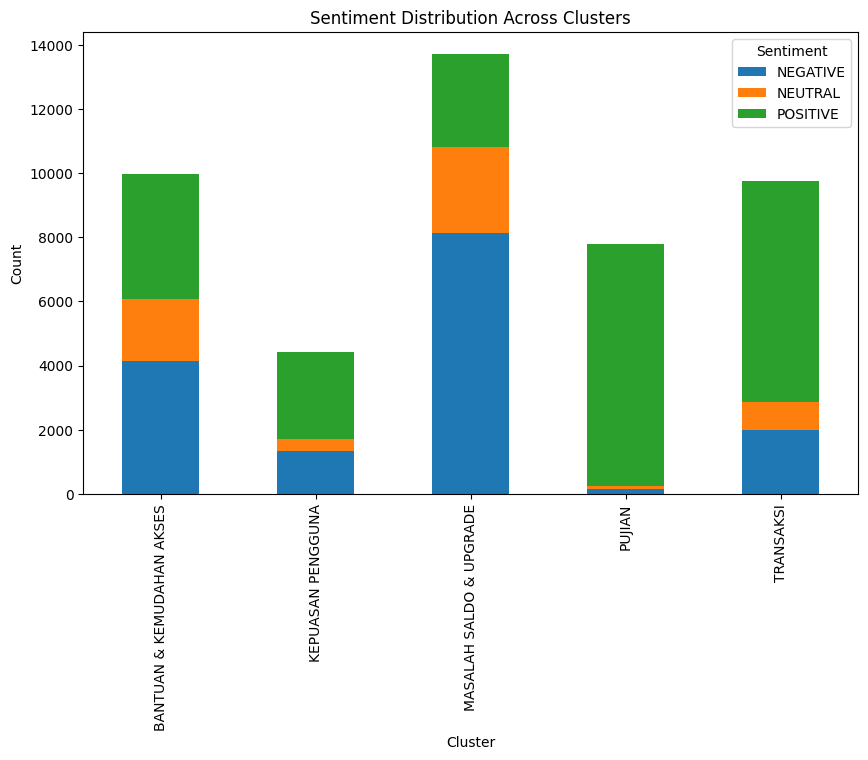

sentimen                   NEGATIVE  NEUTRAL  POSITIVE

aspect                                                

BANTUAN & KEMUDAHAN AKSES      4131     1938      3904

KEPUASAN PENGGUNA              1332      386      2711

MASALAH SALDO & UPGRADE        8136     2668      2909

PUJIAN                          142      110      7544

TRANSAKSI                      1990      882      6875


In [203]:
# Crosstab to see the distribution of sentiments in each cluster
sentiment_cluster_distribution = pd.crosstab(df['aspect'], df['sentimen'])


sentiment_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()
print(sentiment_cluster_distribution)

1. TRANSAKSI

   * Topik "TRANSAKSI" memiliki mayoritas sentimen positif (6875), dengan sebagian besar pengguna menghargai kemudahan dan efisiensi transaksi. Namun, ada juga jumlah yang signifikan dari sentimen negatif (1990), menunjukkan adanya keprihatinan terkait masalah transaksi.
2. PUJIAN

   * Topik "PUJIAN" mendominasi oleh sentimen positif yang sangat tinggi (7544), dengan sedikit sentimen negatif (142). Ini menunjukkan bahwa pengguna secara umum sangat puas dan mengucapkan terima kasih atas layanan atau produk yang diberikan.
3. KEPUASAN PENGGUNA

   * "KEPUASAN PENGGUNA" menunjukkan mayoritas sentimen positif (2711), dengan jumlah sentimen negatif (1332) yang lebih rendah. Ini menunjukkan bahwa kepuasan pengguna ada, tetapi ada juga ruang untuk perbaikan untuk meningkatkan pengalaman pengguna.
4. BANTUAN & KEMUDAHAN AKSES

   *  Topik "BANTUAN & KEMUDAHAN AKSES" menunjukkan campuran hingga mayoritas sentimen negatif (4131), menunjukkan adanya kebutuhan untuk layanan dukungan yang lebih baik. Meskipun ada juga sentimen positif (3904), perbaikan diperlukan dalam area ini.
5. MASALAH SALDO & UPGRADE

   * "MASALAH SALDO & UPGRADE" menyoroti sentimen negatif yang signifikan (8136), menunjukkan adanya ketidakpuasan atau masalah terkait saldo dan masalah upgrade. Ada juga jumlah yang signifikan dari sentimen netral (2668), menunjukkan kompleksitas dalam isu-isu ini.

## Classfication

In [204]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.7898598335523435

Classification Report:

               precision    recall  f1-score   support



    NEGATIVE       0.71      0.82      0.76      3122

     NEUTRAL       0.68      0.16      0.26      1240

    POSITIVE       0.85      0.94      0.89      4770



    accuracy                           0.79      9132

   macro avg       0.75      0.64      0.64      9132

weighted avg       0.78      0.79      0.76      9132



Confusion Matrix:

 [[2545   69  508]

 [ 790  196  254]

 [ 273   25 4472]]


In [205]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8027814279456855

Classification Report:

               precision    recall  f1-score   support



    NEGATIVE       0.75      0.79      0.77      3122

     NEUTRAL       0.61      0.33      0.42      1240

    POSITIVE       0.86      0.93      0.90      4770



    accuracy                           0.80      9132

   macro avg       0.74      0.68      0.70      9132

weighted avg       0.79      0.80      0.79      9132



Confusion Matrix:

 [[2469  207  446]

 [ 581  403  256]

 [ 256   55 4459]]


In [206]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.7934734997809899

Classification Report:

               precision    recall  f1-score   support



    NEGATIVE       0.72      0.80      0.76      3122

     NEUTRAL       0.58      0.28      0.38      1240

    POSITIVE       0.87      0.92      0.89      4770



    accuracy                           0.79      9132

   macro avg       0.72      0.67      0.68      9132

weighted avg       0.78      0.79      0.78      9132



Confusion Matrix:

 [[2490  197  435]

 [ 642  346  252]

 [ 304   56 4410]]


## Insight dan Analysis
1. Performa Model:

 * Logistic Regression memiliki akurasi tertinggi (82.29%) dan performa terbaik
secara keseluruhan dalam hal precision, recall, dan F1-score dibandingkan dengan Naive Bayes dan Random Forest.

 * Naive Bayes menunjukkan kesulitan signifikan dalam memprediksi kategori NEUTRAL, yang menunjukkan bahwa model ini mungkin terlalu sederhana untuk menangani nuansa dalam ulasan aplikasi.
 * Random Forest memberikan keseimbangan yang baik, dengan performa yang baik pada kategori NEGATIVE tetapi sedikit menurun pada kategori POSITIVE.

2. Kesulitan dalam Memisahkan Kategori NEUTRAL:

 * Semua model menunjukkan kesulitan dalam memprediksi kategori NEUTRAL dengan presisi dan recall yang lebih rendah dibandingkan kategori NEGATIVE dan POSITIVE.
 * Ini bisa disebabkan oleh tumpang tindih antara kata-kata yang digunakan dalam ulasan netral dengan ulasan positif atau negatif.
3. Rekomendasi:

 * Peningkatan Data: Mengumpulkan lebih banyak data ulasan, terutama yang berlabel NEUTRAL, dapat membantu model belajar lebih baik.
 *   Feature Engineering: Mencoba teknik feature engineering lainnya, seperti bigram atau trigram, atau menggunakan embeddings yang lebih canggih seperti Word2Vec atau BERT.
 * Modeling: Menggunakan teknik ensemble atau model yang lebih kompleks seperti Gradient Boosting atau Deep Learning untuk mencoba meningkatkan performa lebih lanjut.

## Insight dari classification

hasil klasifikasi diatas dapat dilihat bahwa model dapat mengklasifikasi sentimen dengan baik, namun terdapat beberapa model sentimen netral memiliki hasil yang cukup rendah. hal ini dapat terjadi karena dataset yang digunakan tidak seimbang antara jumlah sentimen negatif, positif dan netral.

dapat dilihat pada jumlah dataset bahwa sentimen netral memiliki jumlah yang paling sedikit diantara sentimen positif dan negatif